##  Machine learning and Social Network Analysis for Precesion world event predections 


The age of social media and social netowrks, that connects the world in unprecendeted ways, has opened up a flood of information. Social network users add layers of information everytime they tweet or post. This project is going to explore the possibility of finding out popularity of certain topics amongst twitter users. The assumption is that tweets convey emotional responces to certain aspects that affect the tweeter. 



This notebook explores the world of Twitter with the use of multiple Unsupervised learning techniques, sentiment analysis and social network analysis in order to predict President's trump populairty amongst twitter users. 


In order to make predictions, the data will be collected from certain chosen dates to be used as training and testing datasets. 

The following is a guidline to the notebook:


1. Data Collection, using Twitter API
2. Data Cleaning and Data exploration
4. Sentemint Analysis, NLP
3. Social network Analysis, graphs on Networkx to explore centralitiy measures
4. Supervised learning to make predictions
5. Validatoin 
6. Conclusion


The Data is collected from the [Twitter API](https://developer.twitter.com/)


## Data Collection

Twitter offers an API that allows researchers and data scientests have access to the twitter Database. In this project The API streamer, which is used to gain access to live tweets. The streamer allows for the lookup of certain topics. Since the project is to measure the popularity of a certain topic, in this case, President Trump.  


In [1]:
#Import modules
%matplotlib inline

#handling data
import pandas as pd
import numpy as np
from scipy import stats
from operator import itemgetter


import community
#handling information
import re
import json
from bs4 import BeautifulSoup 
#handling plots
import matplotlib.pyplot as plt
import seaborn as sns

#for network creation
import networkx as nx


# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [ ]:
import tweepy 
import json
## This part is taken from https://github.com/ugis22/analysing_twitter

## Amazing work by Eugenia and will help be the basis of my analysis



# The information provided here is essential to gain access to the twitter API


consumer_key = ''
consumer_secret = ''

access_token= ''  
access_token_secret = ''


def autorize_twitter_api():
    """
    This function gets the consumer key, consumer secret key, access token 
    and access token secret given by the app created in your Twitter account
    and authenticate them with Tweepy.
    """
    #Get access and costumer key and tokens
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    
    return auth


In [ ]:
# Defining the stream class which is used to get live tweets.


class MyStreamListener(tweepy.StreamListener):
    
    """
    def on_status(self, status):
        print(status.text)
    """
    def __init__(self, filename, api=None):
        self.filename = filename
    
        tweepy.StreamListener.__init__(self, api=api)

        
    def on_data(self, raw_data):

        try:
            with open(self.filename, 'a') as file:
                file.write(raw_data)
  
            
        except Exception as e:
            print(e)
    
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_error disconnects the stream
            return False

In [ ]:
'''
############################## Dont Apply if you have tweets already, will start a new stream of tweets ######################
## Applying the streamer, saving the resulted JSON response in a text file for later use. 

## This part could be improved on by adding the option to add to previously downloaded data and building a database
## in which we can store live tweets on a daily basis

# For realtime streaming

    #Creates the table for storing the tweets
term_to_search = "Trump"
    
    #Connect to the streaming twitter API
api = tweepy.API(wait_on_rate_limit_notify=True)
    
    #Stream the tweets
streamer = tweepy.Stream(auth=autorize_twitter_api(), listener=MyStreamListener(api=api, filename='./tweets2.txt'))
streamer.filter(languages=["en"], track=[term_to_search])   
myStream.disconnect()
'''

## Data Cleaning 

This part involves extensive data cleaning and formatting. Since the information we need is specific, the final DataFrame will only have the most important features necessery to carry out the analysis. 

The first step to cleaning the data is to read the JSON format into a pandas DataFrame. The text of the tweets include hashtags(#), links, and user names (@). These parts are not improtant for our analysis and so, will be removed. The next steps, are to populate the dataframe with the information necessery to carry out the analysis and model fitting. Since the tweets are universal, we are only interested in the US users. 

Twitter has an issue of bots tweeting on behalf of companies or malicious activists. in order to minimize this, the tweets are only going to be the ones that were tweeted from devices, such as iPhones, Android or PC and tablets. the rationale behind this is that usually only upload tweets through other devices. 

In [2]:
## reading the text file into a pandas DataFrame

pd.set_option('display.float_format', lambda x: '%.f' % x)

tweets_df = pd.read_json("tweets.txt", lines=True)
## The columns from the json dictionery

tweets_df.columns

Index(['contributors', 'coordinates', 'created_at', 'display_text_range',
       'entities', 'extended_entities', 'extended_tweet', 'favorite_count',
       'favorited', 'filter_level', 'geo', 'id', 'id_str',
       'in_reply_to_screen_name', 'in_reply_to_status_id',
       'in_reply_to_status_id_str', 'in_reply_to_user_id',
       'in_reply_to_user_id_str', 'is_quote_status', 'lang', 'place',
       'possibly_sensitive', 'quote_count', 'quoted_status',
       'quoted_status_id', 'quoted_status_id_str', 'quoted_status_permalink',
       'reply_count', 'retweet_count', 'retweeted', 'retweeted_status',
       'source', 'text', 'timestamp_ms', 'truncated', 'user',
       'withheld_in_countries'],
      dtype='object')

In [3]:
tweets_df.head()

contributors coordinates          created_at display_text_range  \
0           nan        None 2019-06-08 18:26:22                NaN   
1           nan        None 2019-06-08 18:26:22                NaN   
2           nan        None 2019-06-08 18:26:22                NaN   
3           nan        None 2019-06-08 18:26:22                NaN   
4           nan        None 2019-06-08 18:26:22                NaN   

                                            entities extended_entities  \
0  {'hashtags': [], 'urls': [{'url': 'https://t.c...               NaN   
1  {'hashtags': [], 'urls': [], 'user_mentions': ...               NaN   
2  {'hashtags': [], 'urls': [], 'user_mentions': ...               NaN   
3  {'hashtags': [], 'urls': [{'url': 'https://t.c...               NaN   
4  {'hashtags': [], 'urls': [{'url': 'https://t.c...               NaN   

  extended_tweet  favorite_count  favorited filter_level  ... reply_count  \
0            NaN               0      False          low  ...           0   
1            NaN               0      False          low  ...           0   
2            NaN               0      False          low  ...           0   
3            NaN               0      False          low  ...           0   
4            NaN               0      False          low  ...           0   

   retweet_count  retweeted  \
0              0      False   
1              0      False   
2              0      False   
3              0      False   
4              0      False   

                                    retweeted_status  \
0                                                NaN   
1  {'created_at': 'Sat Jun 08 11:19:12 +0000 2019...   
2  {'created_at': 'Sat Jun 08 12:30:04 +0000 2019...   
3  {'created_at': 'Fri Jun 07 10:24:16 +0000 2019...   
4                                                NaN   

                                              source  \
0  <a href="http://twitter.com/download/android" ...   
1  <a href="http://twitter.com/download/android" ...   
2  <a href="http://twitter.com/download/android" ...   
3  <a href="http://twitter.com/download/iphone" r...   
4  <a href="http://twitter.com/download/iphone" r...   

                                                text            timestamp_ms  \
0  Modi should strengthen ties with the US but no... 2019-06-08 18:26:22.061   
1  RT @maddogpac: THIS IS INSANE. Yes, I'm SHOUTI... 2019-06-08 18:26:22.120   
2  RT @OrenIShiKiddo: ANOTHER Twitter Rule: You m... 2019-06-08 18:26:22.210   
3  RT @RobinsonErick: China prepares to strike ba... 2019-06-08 18:26:22.232   
4  Trump mixes economic and national security, pl... 2019-06-08 18:26:22.283   

   truncated                                               user  \
0      False  {'id': 800613972277751808, 'id_str': '80061397...   
1      False  {'id': 87515824, 'id_str': '87515824', 'name':...   
2      False  {'id': 848206806, 'id_str': '848206806', 'name...   
3      False  {'id': 16026430, 'id_str': '16026430', 'name':...   
4      False  {'id': 135191649, 'id_str': '135191649', 'name...   

  withheld_in_countries  
0                   NaN  
1                   NaN  
2                   NaN  
3                   NaN  
4                   NaN  

[5 rows x 37 columns]

In [4]:
tweets_df.describe()

contributors  favorite_count                  id              id_str  \
count             0           77929               77929               77929   
mean            nan               0 1137433948107673344 1137433948107673344   
std             nan               0       4417442979453       4417442979453   
min             nan               0 1137425650409590784 1137425650409590784   
25%             nan               0 1137430369660280832 1137430369660280832   
50%             nan               0 1137434050275135488 1137434050275135488   
75%             nan               0 1137437752071512064 1137437752071512064   
max             nan               0 1137441383894196224 1137441383894196224   

       in_reply_to_status_id  in_reply_to_status_id_str  in_reply_to_user_id  \
count                   7944                       7944                 8498   
mean     1136404678647362816        1136404678647362816   225979614429474656   
std        17548843904616918          17548843904616918   400189922621143488   
min              24175023099                24175023099                   12   
25%      1137208310108753920        1137208310108753920             25073877   
50%      1137388234959345664        1137388234959345664            270553732   
75%      1137426428002228224        1137426428002228224           4750394662   
max      1137441218491748352        1137441218491748352  1137417985604407296   

       in_reply_to_user_id_str  possibly_sensitive  quote_count  \
count                     8498               16624        77929   
mean        225979614429474656                   0            0   
std         400189922621143488                   0            0   
min                         12                   0            0   
25%                   25073877                   0            0   
50%                  270553732                   0            0   
75%                 4750394662                   0            0   
max        1137417985604407296                   1            0   

         quoted_status_id  quoted_status_id_str  reply_count  retweet_count  
count               18099                 18099        77929          77929  
mean  1133014429185727744   1133014429185727744            0              0  
std     47628575001275152     47628575001275152            0              0  
min            2898879612            2898879612            0              0  
25%   1137054857414754304   1137054857414754304            0              0  
50%   1137311653945663488   1137311653945663488            0              0  
75%   1137373850944114688   1137373850944114688            0              0  
max   1137440811162001408   1137440811162001408            0              0

In [5]:
## functions to clean the tweet stream in order to apply models


# Create a second dataframe to put important information
tweets_final = pd.DataFrame(columns = ["created_at", "id", "in_reply_to_screen_name", "in_reply_to_status_id", "in_reply_to_user_id",
                                      "retweeted_id", "retweeted_screen_name", "user_mentions_screen_name", "user_mentions_id", 
                                       "text", "user_id", "screen_name", "followers_count", 'sentiment','polarity','subjectivity',
                                         'original_author', 'hashtags',
                                        'user_mentions', 'source', 'location'])

# Columns that are going to be the same
equal_columns = ["created_at", "id", "text"]
tweets_final[equal_columns] = tweets_df[equal_columns]
# Get the basic information about user 
def get_basics(tweets_final):
    tweets_final["screen_name"] = tweets_df["user"].apply(lambda x: x["screen_name"])
    tweets_final["user_id"] = tweets_df["user"].apply(lambda x: x["id"])
    tweets_final["followers_count"] = tweets_df["user"].apply(lambda x: x["followers_count"])
    return tweets_final
# Get the user mentions 
def get_usermentions(tweets_final):
    # Inside the tag 'entities' will find 'user mentions' and will get 'screen name' and 'id'
    tweets_final["user_mentions_screen_name"] = tweets_df["entities"].apply(lambda x: x["user_mentions"][0]["screen_name"] if x["user_mentions"] else np.nan)
    tweets_final["user_mentions_id"] = tweets_df["entities"].apply(lambda x: x["user_mentions"][0]["id_str"] if x["user_mentions"] else np.nan)
    return tweets_final
# Get retweets
def get_source(tweets_final):
    
    ## The source of a tweet is where it was composed and uploaded. i.e. Android or iPhone
    tweets_final['source'] = tweets_df['source'].apply(lambda x: BeautifulSoup(x).get_text())
    return tweets_final
def get_retweets(tweets_final):
    # Inside the tag 'retweeted_status' will find 'user' and will get 'screen name' and 'id'    
    tweets_final["retweeted_screen_name"] = tweets_df["retweeted_status"].apply(lambda x: x["user"]["screen_name"] if x is not np.nan else np.nan)
    tweets_final["retweeted_id"] = tweets_df["retweeted_status"].apply(lambda x: x["user"]["id_str"] if x is not np.nan else np.nan)
    return tweets_final
# Get the information about replies
def get_in_reply(tweets_final):
    # Just copy the 'in_reply' columns to the new dataframe
    tweets_final["in_reply_to_screen_name"] = tweets_df["in_reply_to_screen_name"]
    tweets_final["in_reply_to_status_id"] = tweets_df["in_reply_to_status_id"]
    tweets_final["in_reply_to_user_id"]= tweets_df["in_reply_to_user_id"]
    return tweets_final
# Lastly fill the new dataframe with the important information

def get_coordinates(tweets_final):
    # get location based information
    try:
            location = tweets_df['user'].apply(lambda x: x['location'])
    except TypeError:
            location = ''
            
    tweets_final['location'] = location
    
 
## Function  to get hashtags from the JSON file 
## Needs Work!
'''

def get_hashtags(tweets_final):
     # hashtagas and mentiones are saved using comma separted
    hashtags = ", ".join([hashtag_item['text'] for hashtag_item in tweets_df['entities'].apply(lambda x: x['hashtags'])])
    tweets_final['hashtags']= hashtags
    mentions = ", ".join([mention['screen_name'] for mention in tweets_df['entities'].apply(lambda x: x['user_mentions'])])
    tweets_final['user_mentions'] = mentions
    
get_hashtags(tweets_final)
'''
    
def get_fav_count(tweets_final): 
    
    tweets_final['favorite_count'], tweets_final['retweet_count'] = tweets_df['favorite_count'], tweets_df['retweet_count']


## function to apply all other functions
    
def fill_df(tweets_final):
    get_basics(tweets_final)
    get_usermentions(tweets_final)
    get_retweets(tweets_final)
    get_in_reply(tweets_final)
       
    get_coordinates(tweets_final)
    ##get_fav_count(tweets_final)
    get_source(tweets_final)
    
    return tweets_final



In [6]:
## Applying functions previously made to process the data
tweets_final = fill_df(tweets_final)
tweets_final = tweets_final.where((pd.notnull(tweets_final)), None)



In [7]:
## filtering advertisments and tweets originated from devices other than mobile devices, Android, Iphone and computer٥
def filter_source(tweets_final):
    devices = list(set(tweets_final[tweets_final['source'].str.startswith('Twitter')]['source'])) 
    if 'Twitter Ads' in devices:
        devices.remove('Twitter Ads')
    tweets_final = tweets_final[tweets_final['source'].isin(devices)] 
    return tweets_final


tweets_final = filter_source(tweets_final)

In [8]:
## only tweets from the US

tweets_US = tweets_final.loc[tweets_final['location'].str.contains("US", na = False )]
tweets_US.reset_index(drop =True, inplace = True)
tweets_US.head()



created_at                   id in_reply_to_screen_name  \
0 2019-06-08 18:26:22  1137425652414603266                    None   
1 2019-06-08 18:26:22  1137425653790388224                    None   
2 2019-06-08 18:26:24  1137425658777415681                    None   
3 2019-06-08 18:26:24  1137425659528142850                    None   
4 2019-06-08 18:26:24  1137425660866154498                    None   

  in_reply_to_status_id in_reply_to_user_id retweeted_id  \
0                  None                None   1140388614   
1                  None                None   4870230854   
2                  None                None    467726691   
3                  None                None     14247236   
4                  None                None     32871086   

  retweeted_screen_name user_mentions_screen_name user_mentions_id  \
0        lesliebirkland            lesliebirkland       1140388614   
1        Aliciastarr001            Aliciastarr001       4870230854   
2          CheriJacobus              CheriJacobus        467726691   
3                funder                    funder         14247236   
4          kylegriffin1              kylegriffin1         32871086   

                                                text  ...   screen_name  \
0  RT @lesliebirkland: @gatewaypundit After beggi...  ...   tonybiskits   
1  RT @Aliciastarr001: PRISON IS COMING: US Attor...  ...   Maven4Trump   
2  RT @CheriJacobus: I'd rather see us do what's ...  ...        cgmoff   
3  RT @funder: Trump’s freaking out, because he k...  ...    Tumblewolf   
4  RT @kylegriffin1: When Eric and Donald, Jr. we...  ...  BlueWaveMove   

  followers_count  sentiment polarity subjectivity original_author hashtags  \
0             531       None     None         None            None     None   
1            1326       None     None         None            None     None   
2              95       None     None         None            None     None   
3              22       None     None         None            None     None   
4            1035       None     None         None            None     None   

  user_mentions               source             location  
0          None     Twitter for iPad               FL USA  
1          None   Twitter for iPhone  South Carolina, USA  
2          None   Twitter for iPhone   West Virginia, USA  
3          None   Twitter for iPhone         Florida, USA  
4          None  Twitter for Android           Texas, USA  

[5 rows x 21 columns]

In [9]:
'''
#########################################---- Extra -----#############################
# not applied
## This part requires an API which is not for free, however this information could be applied to add another level of information

## Getting more accurate locations
## Since the location part  provided by users is free form, this module finds all geolocation information from free formed locations if applicable
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="twitter_locations")

from geopy.extra.rate_limiter import RateLimiter
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=3)
tweets_US['clean_location'] = tweets_US['location'].apply(geocode)

tweets_US['clean_location'].head()
'''

'\n#########################################---- Extra -----#############################\n# not applied\n## This part requires an API which is not for free, however this information could be applied to add another level of information\n\n## Getting more accurate locations\n## Since the location part  provided by users is free form, this module finds all geolocation information from free formed locations if applicable\nfrom geopy.geocoders import Nominatim\ngeolocator = Nominatim(user_agent="twitter_locations")\n\nfrom geopy.extra.rate_limiter import RateLimiter\ngeocode = RateLimiter(geolocator.geocode, min_delay_seconds=3)\ntweets_US[\'clean_location\'] = tweets_US[\'location\'].apply(geocode)\n\ntweets_US[\'clean_location\'].head()\n'

## Natural Language processing and Sentiment Analysis

In this section the focus will be on the textual data, since tweets involve links, hashtags and emojis. These wont help with our proof of concept, howeve, there are more advanced techniques to make sense of emojis, which in its own is a challenging task. 
For this part the modules used were

1. NLTK for Parsing words and tokenization
2. Textblob for sentiment analysis and subjectivity, must be applied on cleaned up text 
3. VADER sentiment analysis, could be applied on textual information that include emojis

Textblob is an  unsupervised learning technique that was developed and trained on previously gathered textual informaiton. VADER is one of the best models to apply on social media texual information, since it can understand emojis, CAPITLIZATION, and other aspects of a text. 




In [10]:
## Cleaning  texts for textblob. VADER will be applied to semi-filtered-text


import os
import numpy as np
import pandas as pd
import tweepy
import re
import string
from textblob import TextBlob
import preprocessor as p
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


# Happy Emoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)','...','’',
    '<3'
    ])

# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])


#combine sad and happy emoticons
emoticons = emoticons_happy.union(emoticons_sad)

emoji_pattern = emoji_pattern = re.compile(
    u"(\ud83d[\ude00-\ude4f])|"  # emoticons
    u"(\ud83c[\udf00-\uffff])|"  # symbols & pictographs (1 of 2)
    u"(\ud83d[\u0000-\uddff])|"  # symbols & pictographs (2 of 2)
    u"(\ud83d[\ude80-\udeff])|"  # transport & map symbols
    u"(\ud83c[\udde0-\uddff])"  # flags (iOS)
    "+", flags=re.UNICODE)

In [11]:
## Cleaning Data 



def clean_tweets(tweet):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(tweet)

    #after tweepy preprocessing the colon left remain after removing mentions
    #or RT sign in the beginning of the tweet
    tweet = re.sub(r':', '', tweet)
    tweet = re.sub(r'‚Ä¶', '', tweet)
    #replace consecutive non-ASCII characters with a space
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)


    #remove emojis from tweet
    tweet = emoji_pattern.sub(r'', tweet)

    #filter using NLTK library append it to a string
    filtered_tweet = [w for w in word_tokens if not w in stop_words]
    filtered_tweet = []
    #looping through conditions
    for w in word_tokens:
        #check tokens against stop words , emoticons and punctuations
        if w not in stop_words and w not in emoticons and w not in string.punctuation:
            filtered_tweet.append(w)
    return ' '.join(filtered_tweet)
    #print(word_tokens)
    #print(filtered_sentence)






In [12]:
tweets_US.loc[:,'semi_filtered_tweet'] = tweets_US.loc[:,'text'].apply(p.clean)

            #call clean_tweet method for extra preprocessing
tweets_US.loc[:,'filtered_tweet'] = tweets_US.loc[:, 'semi_filtered_tweet'].apply(clean_tweets)

       

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [13]:
tweets_US[['semi_filtered_tweet', 'filtered_tweet']].head()

semi_filtered_tweet  \
0  : After begging to endorse him so he could win...   
1  : PRISON IS COMING: US Attorney Durham 'Very D...   
2  : I'd rather see us do what's right, impeach T...   
3  : Trump’s freaking out, because he knows his i...   
4  : When Eric and Donald, Jr. went on their Iris...   

                                      filtered_tweet  
0               After begging endorse could win Utah  
1  PRISON IS COMING US Attorney Durham 'Very Dial...  
2  I 'd rather see us 's right impeach Trump Hous...  
3  Trump freaking knows impeachment trial coming ...  
4  When Eric Donald Jr. went Irish pub crawl last...

In [14]:
## Sentiment Analysis using TextBlob
def txtblob(tweets_final):
    for i, text in enumerate(tweets_US['filtered_tweet']):
        blob = TextBlob(text)
        tweets_US.at[i, 'sentiment'] = blob.sentiment

            #seperate polarity and subjectivity in to two variables
        tweets_US.at[i, 'polarity'] = tweets_US.at[i, 'sentiment'].polarity
        tweets_US.at[i,'subjectivity'] = tweets_US.at[i, 'sentiment'].subjectivity

    return tweets_US

tweets_US= txtblob(tweets_US)

In [15]:
## making sure we dont null data

tweets_US = tweets_US.astype({'polarity':float, 'subjectivity': float})

In [16]:
## VADER SENTIMENT ANALYSIS
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()
## Sentiment Analysis using TextBlob
def VADER(tweets_US):
    for i, text in enumerate(tweets_US['semi_filtered_tweet']):
        response = analyser.polarity_scores(text)

        #tweets_final.at[i, 'concept'] = response['concepts']

            #seperate polarity and subjectivity in to two variables
        tweets_US.at[i, 'VADER_compound'] = response['compound']
    

    return tweets_US

tweets_US = VADER(tweets_US)




In [17]:
## VADER SENTIMENT ANALYSIS on the same text used for TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()
## Sentiment Analysis using TextBlob
def VADER2(tweets_US):
    for i, text in enumerate(tweets_US['filtered_tweet']):
        response = analyser.polarity_scores(text)

        #tweets_final.at[i, 'concept'] = response['concepts']

            #seperate polarity and subjectivity in to two variables
        tweets_US.at[i, 'VADER_compound2'] = response['compound']
    

    return tweets_US

tweets_US = VADER2(tweets_US)




In [ ]:
### Looking inside our output for null items

tweets_US.describe()

In [18]:
## Creating Categories. The output of our models is a float in the range of -1 to 1 
## -1 means negative sentiment and 1 is positive with 0 being neutral


tweets_US.loc[:,'polarity_cat'] = tweets_US['polarity'].apply(lambda x: 'Positive' if x > 0 else('Neutral' if x == 0 else 'Negative'))
tweets_US.loc[:,'polarity_cat_V'] = tweets_US['VADER_compound'].apply(lambda x: 'Positive' if x > 0 else('Neutral' if x == 0 else 'Negative'))
tweets_US.loc[:,'polarity_cat_V2'] = tweets_US['VADER_compound2'].apply(lambda x: 'Positive' if x > 0 else('Neutral' if x == 0 else 'Negative'))


In [19]:
## This is from Dipanjan Sarkar, https://github.com/dipanjanS

## Functions to validate the models used

from sklearn import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.metrics import roc_curve, auc 


def get_metrics(true_labels, predicted_labels):
    
    print('Accuracy:', np.round(
                        metrics.accuracy_score(true_labels, 
                                               predicted_labels),
                        4))
    print('Precision:', np.round(
                        metrics.precision_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('Recall:', np.round(
                        metrics.recall_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('F1 Score:', np.round(
                        metrics.f1_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
                        

def train_predict_model(classifier, 
                        train_features, train_labels, 
                        test_features, test_labels):
    # build model    
    classifier.fit(train_features, train_labels)
    # predict using model
    predictions = classifier.predict(test_features) 
    return predictions    


def display_confusion_matrix(true_labels, predicted_labels, classes=[1,0]):
    
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels, 
                                  labels=classes)
    cm_frame = pd.DataFrame(data=cm, 
                            columns=pd.MultiIndex(levels=[['Predicted:'], classes], 
                                                  labels=level_labels), 
                            index=pd.MultiIndex(levels=[['Actual:'], classes], 
                                                labels=level_labels)) 
    print(cm_frame) 


def display_confusion_matrix_pretty(true_labels, predicted_labels, classes=[1,0]):
    
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels, 
                                  labels=classes)
    cm_frame = pd.DataFrame(data=cm, 
                            columns=pd.MultiIndex(levels=[['Predicted:'], classes], 
                                                  codes=level_labels), 
                            index=pd.MultiIndex(levels=[['Actual:'], classes], 
                                                codes=level_labels)) 
    return cm_frame    
    
def display_classification_report(true_labels, predicted_labels, classes=[1,0]):

    report = metrics.classification_report(y_true=true_labels, 
                                           y_pred=predicted_labels, 
                                           labels=classes) 
    print(report)
    
    
    
def display_model_performance_metrics(true_labels, predicted_labels, classes=[1,0]):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    print('\nModel Classification report:')
    print('-'*30)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels, 
                                  classes=classes)
    print('\nPrediction Confusion Matrix:')
    print('-'*30)
    display_confusion_matrix(true_labels=true_labels, predicted_labels=predicted_labels, 
                             classes=classes)


def plot_model_decision_surface(clf, train_features, train_labels,
                                plot_step=0.02, cmap=plt.cm.RdYlBu,
                                markers=None, alphas=None, colors=None):
    
    if train_features.shape[1] != 2:
        raise ValueError("X_train should have exactly 2 columnns!")
    
    x_min, x_max = train_features[:, 0].min() - plot_step, train_features[:, 0].max() + plot_step
    y_min, y_max = train_features[:, 1].min() - plot_step, train_features[:, 1].max() + plot_step
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    clf_est = clone(clf)
    clf_est.fit(train_features,train_labels)
    if hasattr(clf_est, 'predict_proba'):
        Z = clf_est.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    else:
        Z = clf_est.predict(np.c_[xx.ravel(), yy.ravel()])    
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap)
    
    le = LabelEncoder()
    y_enc = le.fit_transform(train_labels)
    n_classes = len(le.classes_)
    plot_colors = ''.join(colors) if colors else [None] * n_classes
    label_names = le.classes_
    markers = markers if markers else [None] * n_classes
    alphas = alphas if alphas else [None] * n_classes
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y_enc == i)
        plt.scatter(train_features[idx, 0], train_features[idx, 1], c=color,
                    label=label_names[i], cmap=cmap, edgecolors='black', 
                    marker=markers[i], alpha=alphas[i])
    plt.legend()
    plt.show()


def plot_model_roc_curve(clf, features, true_labels, label_encoder=None, class_names=None):
    
    ## Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    if hasattr(clf, 'classes_'):
        class_labels = clf.classes_
    elif label_encoder:
        class_labels = label_encoder.classes_
    elif class_names:
        class_labels = class_names
    else:
        raise ValueError('Unable to derive prediction classes, please specify class_names!')
    n_classes = len(class_labels)
    y_test = label_binarize(true_labels, classes=class_labels)
    if n_classes == 2:
        if hasattr(clf, 'predict_proba'):
            prob = clf.predict_proba(features)
            y_score = prob[:, prob.shape[1]-1] 
        elif hasattr(clf, 'decision_function'):
            prob = clf.decision_function(features)
            y_score = prob[:, prob.shape[1]-1]
        else:
            raise AttributeError("Estimator doesn't have a probability or confidence scoring system!")
        
        fpr, tpr, _ = roc_curve(y_test, y_score)      
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='ROC curve (area = {0:0.2f})'
                                 ''.format(roc_auc),
                 linewidth=2.5)
        
    elif n_classes > 2:
        if hasattr(clf, 'predict_proba'):
            y_score = clf.predict_proba(features)
        elif hasattr(clf, 'decision_function'):
            y_score = clf.decision_function(features)
        else:
            raise AttributeError("Estimator doesn't have a probability or confidence scoring system!")

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        ## Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        ## Compute macro-average ROC curve and ROC area
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        # Finally average it and compute AUC
        mean_tpr /= n_classes
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        ## Plot ROC curves
        plt.figure(figsize=(6, 4))
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]), linewidth=3)

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]), linewidth=3)

        for i, label in enumerate(class_labels):
            plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                           ''.format(label, roc_auc[i]), 
                     linewidth=2, linestyle=':')
    else:
        raise ValueError('Number of classes should be atleast 2 or more')
        
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


display_confusion_matrix_pretty(true_labels=tweets_US.polarity_cat_V, 
                                    predicted_labels=tweets_US.polarity_cat, 
                                    classes=['Positive', 'Neutral', 'Negative'])

Predicted:                 
                   Positive Neutral Negative
Actual: Positive       1961    1670      612
        Neutral         595    1998      591
        Negative        945    1786     1835

In [20]:
display_confusion_matrix_pretty(true_labels=tweets_US.polarity_cat_V, 
                                    predicted_labels=tweets_US.polarity_cat_V2, 
                                    classes=['Positive', 'Neutral', 'Negative'])

Predicted:                 
                   Positive Neutral Negative
Actual: Positive       3950      19      274
        Neutral          75    3059       50
        Negative        170      31     4365

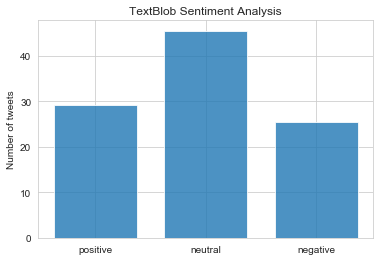

In [35]:
pos = len(tweets_US[tweets_US.polarity > 0]) 
neg = len(tweets_US[tweets_US.polarity < 0]) 
neu = len(tweets_US[tweets_US.polarity == 0]) 

y = [pos/(pos+neg+neu)*100, neu/(pos+neg+neu) *100, neg/(pos+neg+neu) *100]  # vector of y-values 
fig, ax = plt.subplots() 
plt.title("TextBlob Sentiment Analysis") 
plt.ylabel('Number of tweets') 
plt.xticks(range(len(y)), ['positive','neutral',  'negative']) 
plt.bar(range(len(y)), height=y, width = 0.75, align = 'center', alpha = 0.8) 
 
plt.show()  
fig.savefig("Textblob.png")


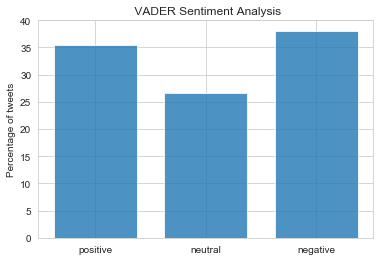

In [36]:
pos = len(tweets_US[tweets_US.VADER_compound > 0]) 
neg = len(tweets_US[tweets_US.VADER_compound < 0]) 
neu = len(tweets_US[tweets_US.VADER_compound == 0]) 

y = [pos/(pos+neg+neu)*100,  neu/(pos+neg+neu) *100, neg/(pos+neg+neu) *100]  # vector of y-values 
fig, ax = plt.subplots() 
plt.title(" VADER Sentiment Analysis") 
plt.ylabel('Percentage of tweets') 
plt.xticks(range(len(y)), ['positive', 'neutral', 'negative']) 
plt.bar(range(len(y)), height=y, width = 0.75, align = 'center', alpha = 0.8) 
 
plt.show()  

fig.savefig("VADER.png")

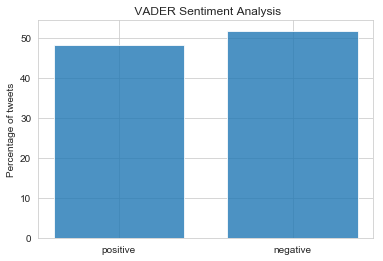

In [108]:
pos = len(tweets_US[tweets_US.VADER_compound > 0]) 
neg = len(tweets_US[tweets_US.VADER_compound < 0]) 
#neu = len(tweets_US[tweets_US.VADER_compound == 0]) 

y = [pos/(pos+neg)*100,   neg/(pos+neg) *100]  # vector of y-values 
fig, ax = plt.subplots() 
plt.title(" VADER Sentiment Analysis") 
plt.ylabel('Percentage of tweets') 
plt.xticks(range(len(y)), ['positive', 'negative']) 
plt.bar(range(len(y)), height=y, width = 0.75, align = 'center', alpha = 0.8) 
 

plt.show()  

fig.savefig("finalresult.png")

In [109]:
binom_test((pos,neg), p=0.5)

0.0006010784033772297

## Model Results 

As is shown from the confusion matrix that was made to compare the models against each other, this way is not to validate one model over the other, or the models' performances. 
VADER is used extensivly on social media text, involving emojis, capitalization and informal english. Textblob on the other hand was fed a cleaned up version of the text. 


The results show that Textblob didnt capture as much of the sentiments captured by VADER, assigining a most of the tweets as neutral, which means it couldn't capture the sentiment of a cleaned up text that might have involved emojis which are very descriptive to the sentiment of the tweet. The bar graphs shows this discrepency between the two models.

As a way to check the importance of emojis and other factors, The second confusion matrix compares a VADER model applied on the cleaned up text that was fed to TextBlob and the output of the regular VADER applied to a semi cleaned up text, stripped only of hashtags links and mentions. There is a minor difference in the outcome. 
The coming part is to analyse the output of the VADER model, to see if our assumptions would hold. 


## Data Analysis

In this part, the results of the models will be shown in the form of a word cloud, which shows the most used words in both, positive and negative sentiments. This will help demonstrate the differences between the models and which words had the biggest effect on the sentiment result. This words could be used as trigger words, which would draw a reaction and could be used often to attract the groups of which the message is targeting. 

we will vectorize the words in the all of the tweets availble, creating a count vector which will have the number a word appeared the most. 




In [51]:
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfVectorizer
)
#Vectorization for Data Visualization
def vectorization(table):
    #CountVectorizer will convert a collection of text documents to a matrix of token counts
    #Produces a sparse representation of the counts 
    #Initialize
    vector = CountVectorizer( ngram_range = (2,2))
    #We fit and transform the vector created
    frequency_matrix = vector.fit_transform(table.filtered_tweet)
    #Sum all the frequencies for each word
    sum_frequencies = np.sum(frequency_matrix, axis=0)
    #Now we use squeeze to remove single-dimensional entries from the shape of an array that we got from applying np.asarray to
    #the sum of frequencies.
    frequency = np.squeeze(np.asarray(sum_frequencies))
    #Now we get into a dataframe all the frequencies and the words that they correspond to
    frequency_df = pd.DataFrame([frequency], columns=vector.get_feature_names()).transpose()
    return frequency_df
## WordCloud Functoin

def word_cloud(tweets):
    
    stopwords = set(STOPWORDS)
    #Now we store the tweets into a series to be able to process 
    #tweets_list = pd.Series([t for t in tweet_table.tweet]).str.cat(sep=' ')  
    #We generate the wordcloud using the series created and the mask 
    word_cloud = WordCloud(width=2000, height=1000, max_font_size=200, background_color="black", max_words=2000, contour_width=1, 
                           contour_color="steelblue", colormap="nipy_spectral", stopwords=["Trump"])
    word_cloud.generate(tweets)
    
    #wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(tweets_list)
    
    #Now we plot both figures, the wordcloud and the mask
    #plt.figure(figsize=(15,15))
    fig = plt.figure(figsize=(10,10))
    plt.imshow(word_cloud, interpolation="hermite")
    plt.axis("off")
    #plt.imshow(avengers_mask, cmap=plt.cm.gray, interpolation="bilinear")
    #plt.axis("off")    
    plt.show()
    fig.savefig("wordcloud.png")
    
## graph
def graph(word_frequency, sent):
    labels = word_frequency[0][1:51].index
    title = "Word Frequency for %s" %sent
    #Plot the figures
    fig = plt.figure(figsize=(20,10))
    plt.bar(np.arange(50), word_frequency[0][1:51], width = 0.8, color = sns.color_palette("bwr"), alpha=0.5, 
            edgecolor = "black", capsize=8, linewidth=1);
    plt.xticks(np.arange(50), labels, rotation=90, size=14);
    plt.xlabel("50 more frequent words", size=14);
    plt.ylabel("Frequency", size=14);
    #plt.title('Word Frequency for %s', size=18) %sent;
    plt.title(title, size=18)
    plt.grid(False);
    plt.gca().spines["top"].set_visible(False);
    plt.gca().spines["right"].set_visible(False);
    plt.show()
    fig.savefig(sent + "frequency.png")
## Regression plot function    
def regression_graph(table):
    table = table[1:]
    #We set the style of seaborn
    sns.set_style("whitegrid")   
    #Initialize the figure
    plt.figure(figsize=(6,6))
    
    #we obtain the points from matplotlib scatter
    points = plt.scatter(table["Positive"], table["Negative"], c=table["Positive"], s=75, cmap="bwr")
    #graph the colorbar
    plt.colorbar(points)
    #we graph the regplot from seaborn
    sns.regplot(x="Positive", y="Negative",fit_reg=False, scatter=False, color=".1", data=table)
    plt.xlabel("Frequency for Positive Tweets", size=14)
    plt.ylabel("Frequency for Negative Tweets", size=14)
    plt.title("Word frequency in Positive vs. Negative Tweets", size=14)
    plt.grid(False)
    sns.despine()

In [45]:
   #First we draw a word cloud
    #For All tweets
word_cloud(pd.Series([t for t in tweets_US.filtered_tweet]).str.cat(sep=' ')) 

    #For positive tweets 
word_cloud(pd.Series([t for t in tweets_US[tweets_US.polarity_cat_V == "Positive"].filtered_tweet]).str.cat(sep=' '))   
    #For negative tweets
word_cloud(pd.Series([t for t in tweets_US[tweets_US.polarity_cat_V == "Negative"].filtered_tweet]).str.cat(sep=' '))

KeyboardInterrupt: 

The results of the wordcloud are quiet interesting, we see that some of the most used words for each positive or negative sentiment and from that, it seems like positive sentiment tweets are usually in favor of the president, we see border secured there, we see apply tarrifs, some talk about nancy pelosi. on the other hand the negative sentiment tweets talk about the key issues usually used by those who are not in favor of the president, we see the muller report being mentioned a lot, impeachment is also there. The assumption that negative and positive sentiment truley reflect the percentage of those who are in favor or those who are not in favor of the topic (i.e. the president)  

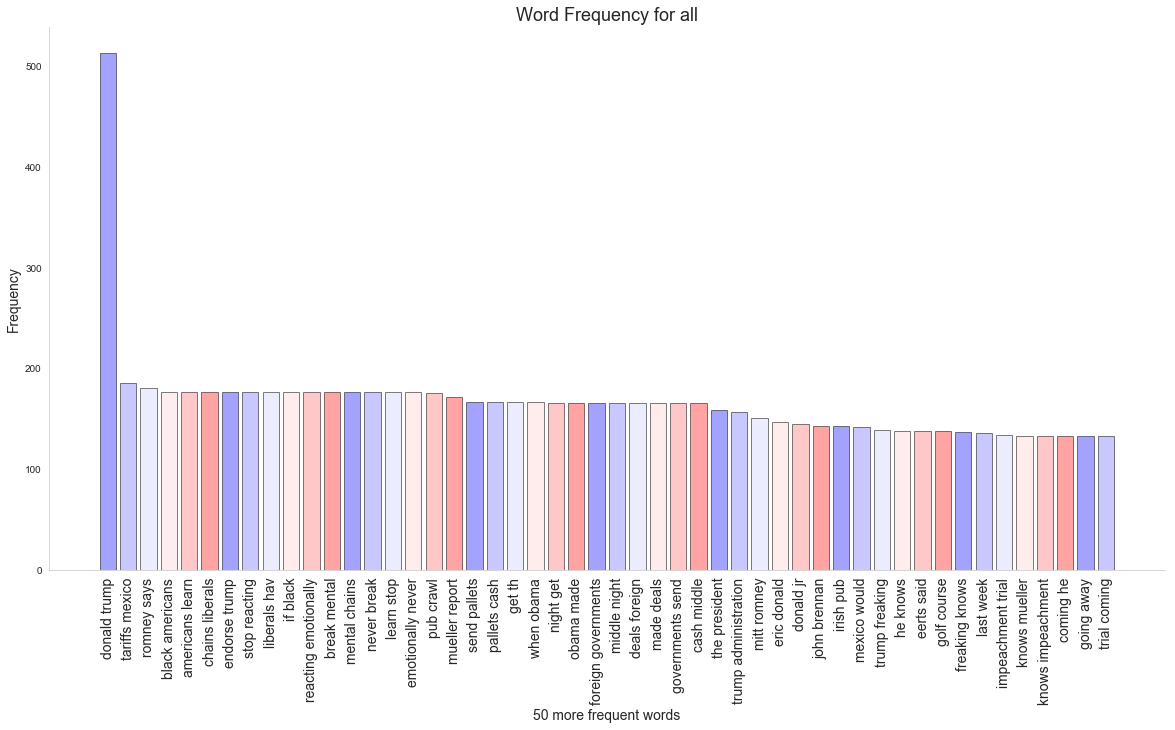

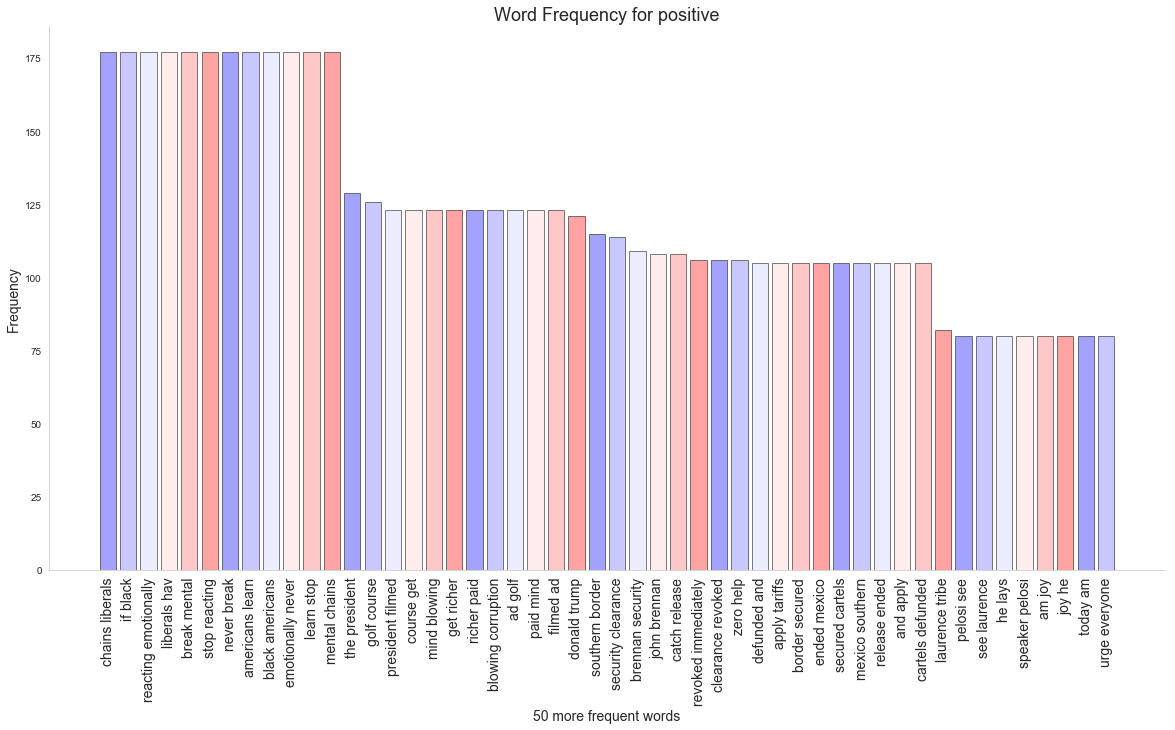

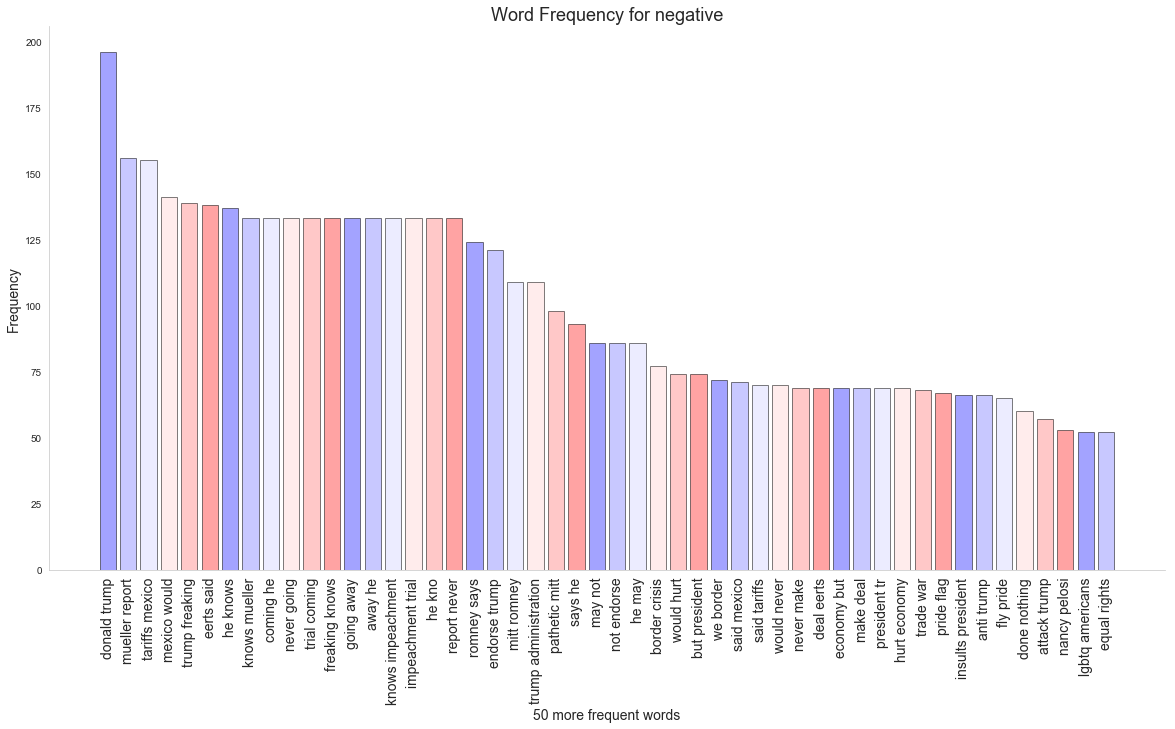

In [52]:
word_frequency = vectorization(tweets_US).sort_values(0, ascending = False)
word_frequency_pos = vectorization(tweets_US[tweets_US['polarity_cat_V'] == 'Positive']).sort_values(0, ascending = False)
word_frequency_neg = vectorization(tweets_US[tweets_US['polarity_cat_V'] == 'Negative']).sort_values(0, ascending = False)

    #Graph with frequency words all, positive and negative tweets and get the frequency
graph(word_frequency, 'all')
graph(word_frequency_pos, 'positive')
graph(word_frequency_neg, 'negative')

The bar graph captures some of the information that were discussed before in the word cloud. however a use of n-grams would help show a much nuanced look at the frequency of words. 

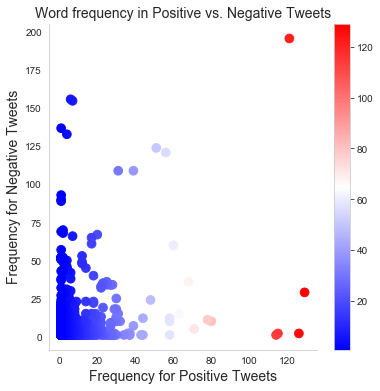

In [26]:
table_regression = pd.concat([word_frequency_pos, word_frequency_neg], axis=1, sort=False)
table_regression.columns = ["Positive", "Negative"]
regression_graph(table_regression)

the plot above shows the frequency of words in both negative and positive sentemint, with most of the negative having more words in them, maybe Ranting, against a more direct positive comment. 

In [27]:
tweets_US  = tweets_US[pd.notnull(tweets_US['VADER_compund'])]

KeyError: 'VADER_compund'

## Network Analysis


This part is to analyse the network in the lookout for the most influintial persons. In order to make good decisions regarding how to reach the most number of people, then those found to connect to the majority people. This will help with marketing efforts, since these people will reach to the most number of people. 

In [53]:
# Get the interactions between the different users
def get_interactions(row):
    # From every row of the original dataframe
    # First we obtain the 'user_id' and 'screen_name'
    user = row["user_id"], row["screen_name"], row['polarity_cat_V']
    # Be careful if there is no user id
    if user[0] is None:
        return (None, None), []
    
    # The interactions are going to be a set of tuples
    interactions = set()
    # Add all interactions 
    # First, we add the interactions corresponding to replies adding the id and screen_name
    interactions.add((row["in_reply_to_user_id"], row["in_reply_to_screen_name"]))
    # After that, we add the interactions with retweets
    interactions.add((row["retweeted_id"], row["retweeted_screen_name"]))
    # And later, the interactions with user mentions
    interactions.add((row["user_mentions_id"], row["user_mentions_screen_name"]))
    
    
    
    # Discard if user id is in interactions
    interactions.discard((row["user_id"], row["screen_name"]))
    # Discard all not existing values
    interactions.discard((None, None))
    # Return user and interactions
    return user, interactions

In [54]:
graph = nx.Graph()
graph2 = nx.Graph()

In [92]:
tweets_pos_neg = tweets_US[tweets_US.polarity_cat_V != 'Neutral']

In [93]:
tweets_pos_neg.reset_index(inplace = True)

In [94]:
for index, tweet in tweets_pos_neg.iterrows():
    user, interactions = get_interactions(tweet)
    user_id, user_name, sentiment = user
    tweet_id = tweet["id"]
    #tweet_sent = tweet["sentiment"]
    for interaction in interactions:
        int_id, int_name = interaction
        graph.add_edge(user_id, int_id, tweet_id=tweet_id)

        graph.node[user_id]["name"] = user_name
        graph.node[user_id]['sentiment'] = sentiment
        graph.node[int_id]["name"] = int_name
        graph.node[int_id]["sentiment"] = sentiment

In [95]:
for index, tweet in tweets_US.iterrows():
    user, interactions = get_interactions(tweet)
    user_id, user_name, sentiment = user
    tweet_id = tweet["id"]
    #tweet_sent = tweet["sentiment"]
    for interaction in interactions:
        int_id, int_name = interaction
        graph2.add_edge(user_id, int_id, tweet_id=tweet_id)

        graph2.node[user_id]["name"] = user_name
        graph2.node[user_id]["sentiment"] = sentiment
        graph2.node[int_id]["name"] = int_name
        graph2.node[int_id]["sentiment"] = sentiment

In [96]:
print(f"There are {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges present in the Graph")

There are 7110 nodes and 9421 edges present in the Graph


In [116]:
degrees = [val for (node, val) in graph.degree()]

print(f"The maximum degree of the Graph is {np.max(degrees)}")   
print(f"The minimum degree of the Graph is {np.min(degrees)}")
print(f"The average degree of the nodes in the Graph is {np.mean(degrees):.1f}")  
print(f"The most frequent degree of the nodes found in the Graph is {stats.mode(degrees)[0][0]}")
if nx.is_connected(graph):
    print("The graph is connected")
else:
    print("The graph is not connected")
    
print(f"There are {nx.number_connected_components(graph)} connected components in the Graph")

The maximum degree of the Graph is 341
The minimum degree of the Graph is 1
The average degree of the nodes in the Graph is 2.7
The most frequent degree of the nodes found in the Graph is 1
The graph is not connected
There are 639 connected components in the Graph


In [98]:
len(nx.get_node_attributes(graph, 'sentiment').values())

7110

In [99]:
largest_subgraph = max(nx.connected_component_subgraphs(graph), key=len)
smallest_subgraph = min(nx.connected_component_subgraphs(graph), key=len)

In [100]:
largest_subgraph2 = max(nx.connected_component_subgraphs(graph2), key=len)
smallest_subgraph2 = min(nx.connected_component_subgraphs(graph2), key=len)

In [113]:
eigenvector_centrality = nx.eigenvector_centrality(largest_subgraph)
closeness_centrality = nx.closeness_centrality(largest_subgraph)
degree_centrality = nx.degree_centrality(largest_subgraph)

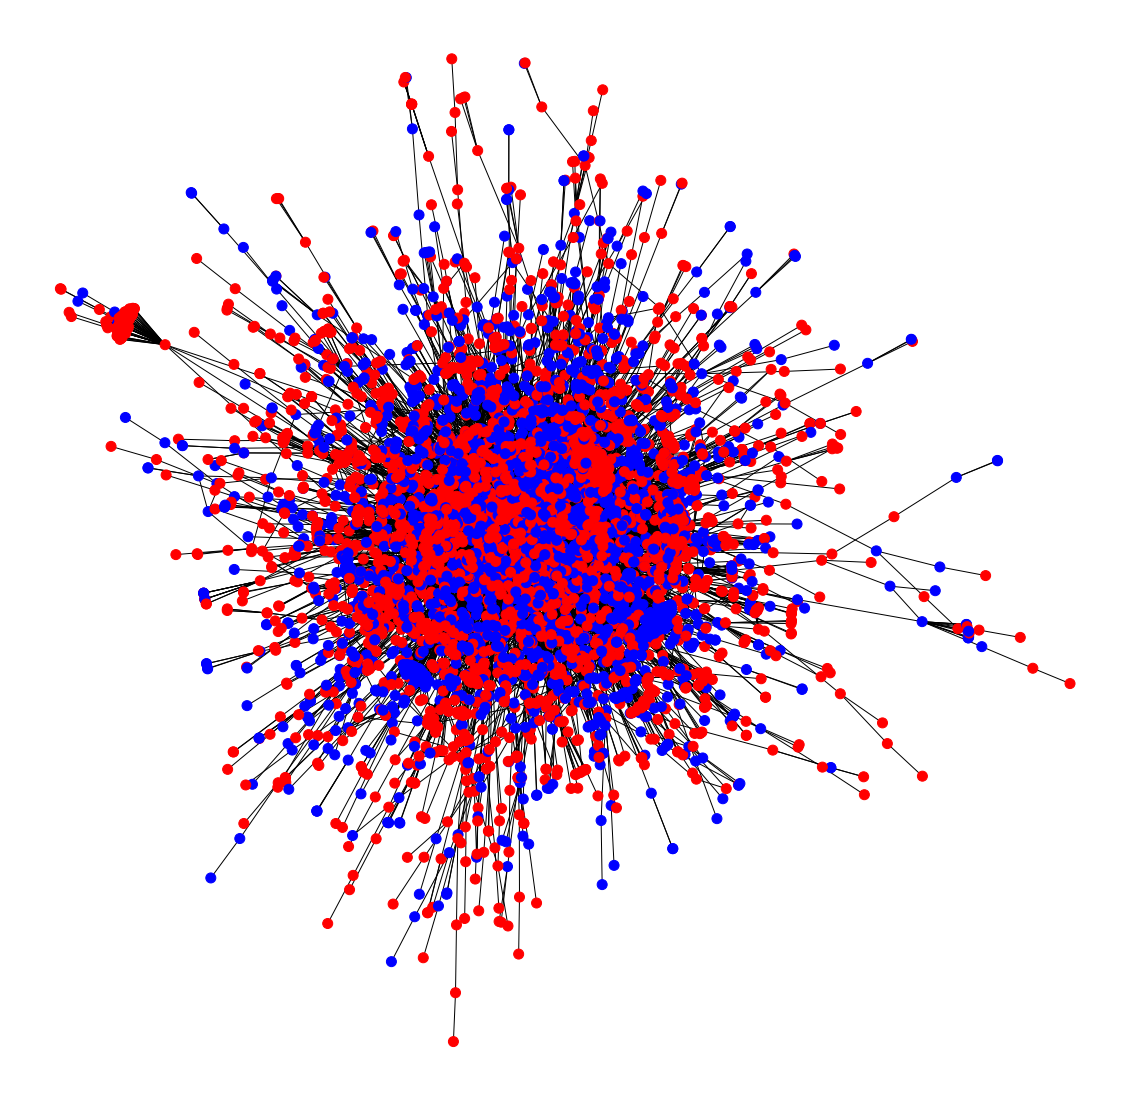

In [101]:
pos = nx.spring_layout(largest_subgraph)
betCent = nx.betweenness_centrality(largest_subgraph, normalized=True, endpoints=True)
#node_color = [20000.0 * graph2.degree(v) for v in largest_subgraph]
color_map = []
for node in nx.get_node_attributes(largest_subgraph,'sentiment').values():
    if node == 'Positive':
        color_map.append('blue')
    else: 
        color_map.append('red')
node_size =  [v * 10000 for v in betCent.values()]
fig =plt.figure(figsize=(20,20))
nx.draw_networkx(largest_subgraph, pos=pos, with_labels=False,
                 node_color = color_map
                ,node_size = 100 )
plt.axis('off')
fig.savefig("reg+graph.png")

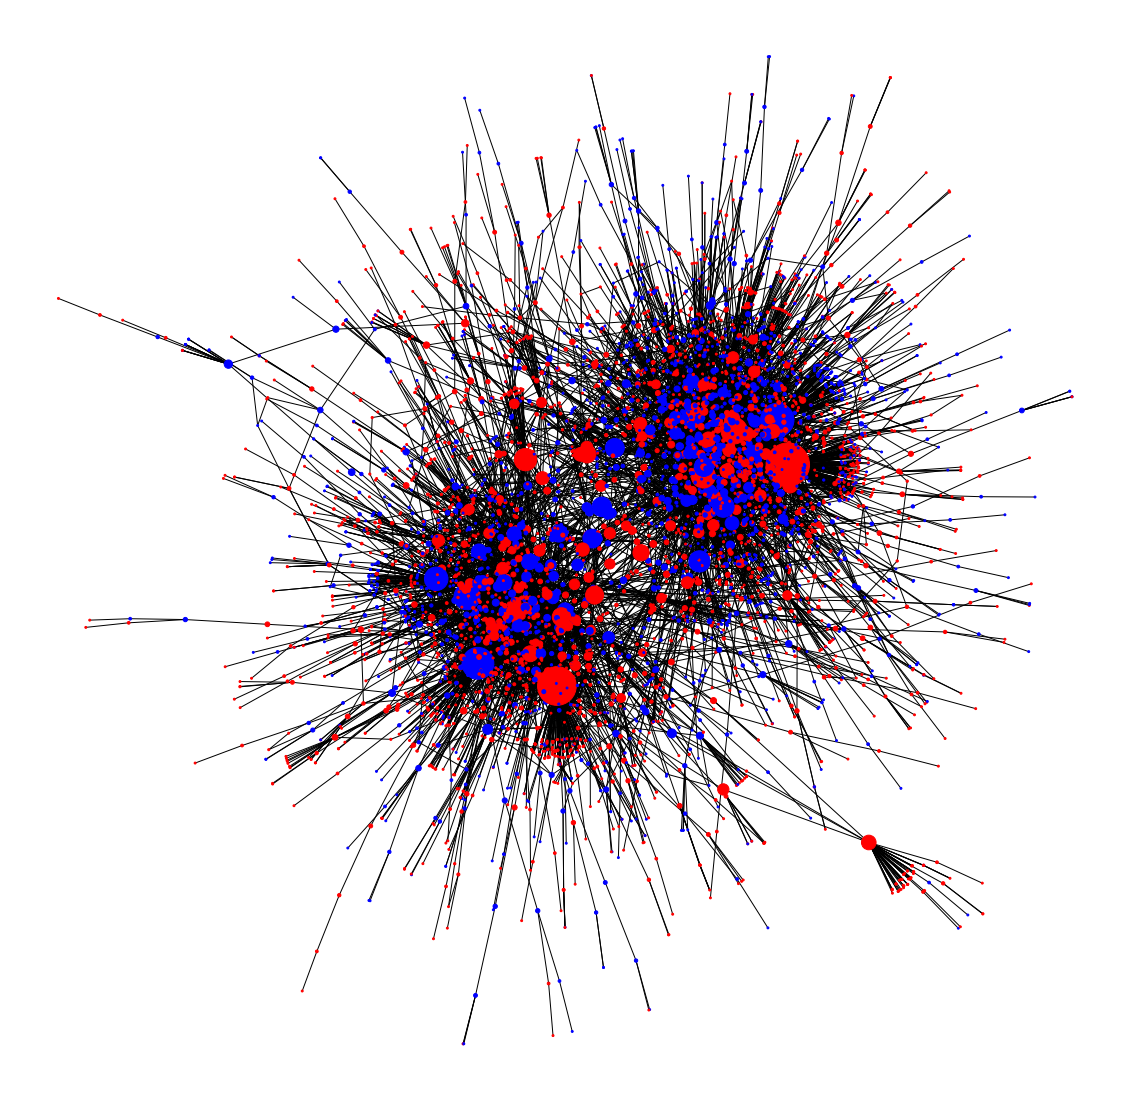

In [102]:
pos = nx.spring_layout(largest_subgraph)
betCent = nx.betweenness_centrality(largest_subgraph, normalized=True, endpoints=True)
#node_color = [20000.0 * graph2.degree(v) for v in largest_subgraph]
color_map = []
for node in nx.get_node_attributes(largest_subgraph,'sentiment').values():
    if node == 'Positive':
        color_map.append('blue')
    else: 
        color_map.append('red')
node_size =  [v * 10000 for v in betCent.values()]

fig = plt.figure(figsize=(20,20))
nx.draw_networkx(largest_subgraph, pos=pos, with_labels=False,
                 node_color = color_map
                ,node_size = node_size )
plt.axis('off')
fig.savefig("betGraph.png")

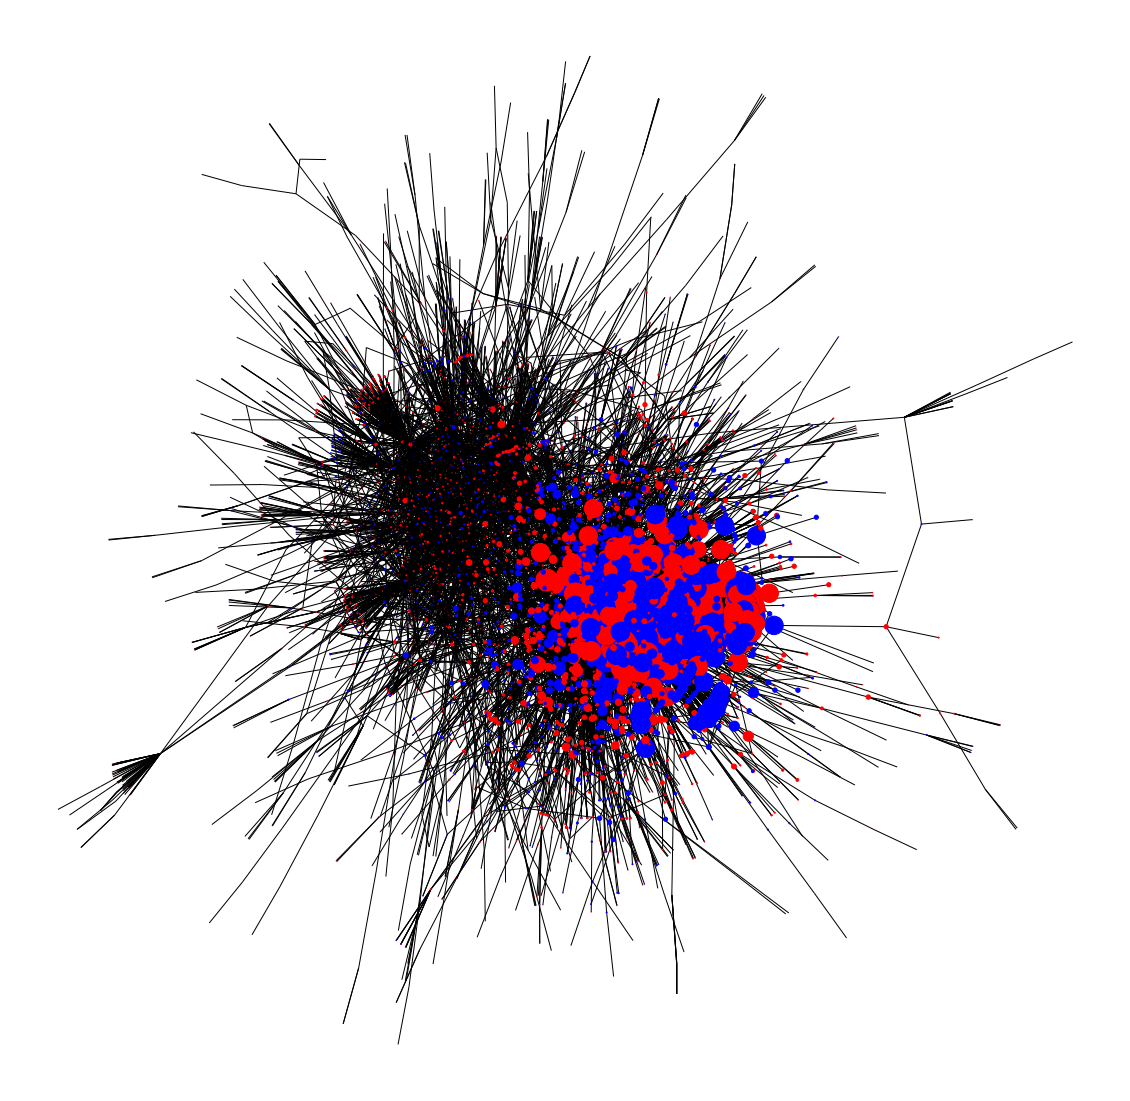

In [118]:
pos = nx.spring_layout(largest_subgraph)

color_map = []
for node in nx.get_node_attributes(largest_subgraph,'sentiment').values():
    if node == 'Positive':
        color_map.append('blue')
    else: 
        color_map.append('red')
node_size =  [v * 10000 for v in eigenvector_centrality.values()]

fig = plt.figure(figsize=(20,20))
nx.draw_networkx(largest_subgraph, pos=pos, with_labels=False,
                 node_color = color_map
                ,node_size = node_size )
plt.axis('off')
fig.savefig("eigenGraph.png")


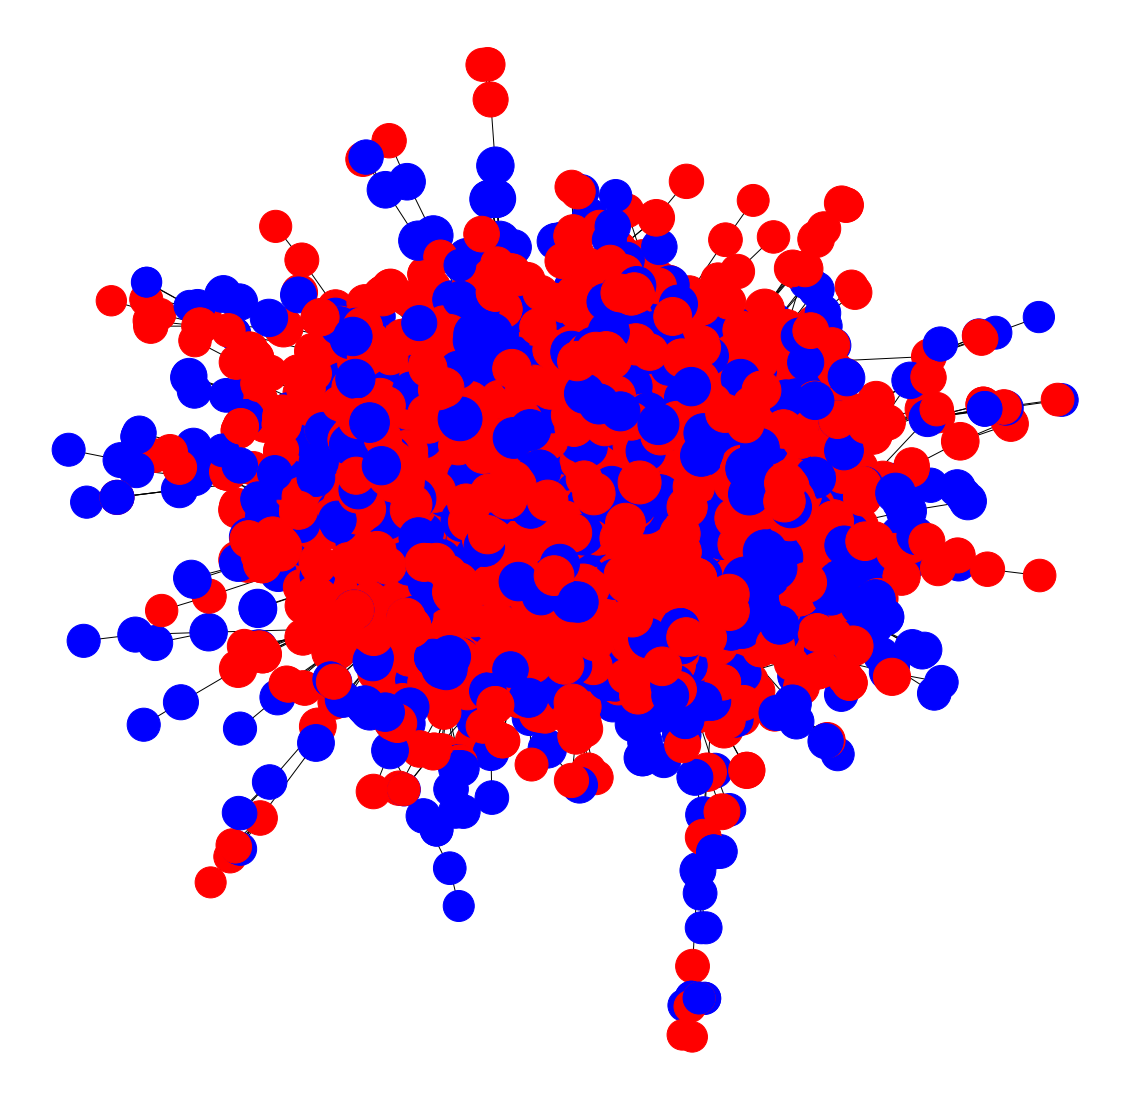

In [74]:
pos = nx.spring_layout(largest_subgraph)

color_map = []
for node in nx.get_node_attributes(largest_subgraph,'sentiment').values():
    if node == 'Positive':
        color_map.append('blue')
    else: 
        color_map.append('red')
node_size =  [v * 10000 for v in closeness_centrality.values()]

fig = plt.figure(figsize=(20,20))
nx.draw_networkx(largest_subgraph, pos=pos, with_labels=False,
                 node_color = color_map
                ,node_size = node_size )
plt.axis('off')
fig.savefig("closnessGraph.png")

In [117]:
largest_degrees = [val for (node, val) in largest_subgraph.degree()]

print(f"The maximum degree of the Graph is {np.max(largest_degrees)}")   
print(f"The minimum degree of the Graph is {np.min(largest_degrees)}")
print(f"The average degree of the nodes in the Graph is {np.mean(largest_degrees):.1f}")  
print(f"The most frequent degree of the nodes found in the Graph is {stats.mode(largest_degrees)[0][0]}")
if nx.is_connected(largest_subgraph):
    print("The graph is connected")
else:
    print("The graph is not connected")
    
print(f"There are {nx.number_connected_components(largest_subgraph)} connected components in the Graph")

The maximum degree of the Graph is 341
The minimum degree of the Graph is 1
The average degree of the nodes in the Graph is 3.1
The most frequent degree of the nodes found in the Graph is 1
The graph is connected
There are 1 connected components in the Graph


In [110]:
import operator

#betCent2 = nx.betweenness_centrality(largest_subgraph, normalized=True, endpoints=True)
print(nx.get_node_attributes(largest_subgraph, 'sentiment')[max(betCent.items(), key=operator.itemgetter(1))[0]])
print(nx.get_node_attributes(largest_subgraph, 'name')[max(betCent.items(), key=operator.itemgetter(1))[0]])

Negative
charliekirk11


In [115]:
max(betCent.items(), key=operator.itemgetter(1))[1]

max(eigenvector_centrality.items(), key=operator.itemgetter(1))

('292929271', 0.6454517118757996)

In [114]:
print(nx.get_node_attributes(largest_subgraph, 'sentiment')[max(eigenvector_centrality.items(), key=operator.itemgetter(1))[0]])
print(nx.get_node_attributes(largest_subgraph, 'name')[max(eigenvector_centrality.items(), key=operator.itemgetter(1))[0]])

Negative
charliekirk11


In [ ]:
'''
## Emotions

import json
from ibm_watson import NaturalLanguageUnderstandingV1
from ibm_watson.natural_language_understanding_v1 \
    import Features, EntitiesOptions, KeywordsOptions

natural_language_understanding = NaturalLanguageUnderstandingV1(
    version='2018-11-16',
    iam_apikey='{apikey}',
    url='{url}')

response = natural_language_understanding.analyze(
    text='IBM is an American multinational technology company '
    'headquartered in Armonk, New York, United States, '
    'with operations in over 170 countries.',
    features=Features(
        entities=EntitiesOptions(emotion=True, sentiment=True, limit=2),
        keywords=KeywordsOptions(emotion=True, sentiment=True,
                                 limit=2))).get_result()

print(json.dumps(response, indent=2))
'''

In [78]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(tweets_US.semi_filtered_tweet))

#print(data_words[:1])

In [79]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
#print(trigram_mod[bigram_mod[data_words[0]]])
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#print(data_lemmatized[:1])

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
#print(corpus[:1])

In [80]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [81]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -17.412303026525112

Coherence Score:  0.3867231631411572


In [82]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=       x  y  topics  cluster  Freq
topic                             
13     0  0       1        1    27
10     0 -0       2        1     9
14     0  0       3        1     8
17    -0  0       4        1     5
12     0  0       5        1     5
19     0 -0       6        1     5
6      0  0       7        1     5
2      0 -0       8        1     5
15    -0  0       9        1     4
16     0 -0      10        1     4
3      0 -0      11        1     4
5     -0  0      12        1     3
7      0  0      13        1     3
18    -0  0      14        1     3
0     -0  0      15        1     2
1     -0  0      16        1     2
9     -0  0      17        1     2
11    -0  0      18        1     1
8     -0  0      19        1     1
4     -0 -0      20        1     0, topic_info=     Category  Freq            Term  Total  loglift  logprob
28    Default 16616           trump  16616       30       30
48    Default  4044       president   4044       29       29
56    Default  2844          mexico   2844       28       28
152   Default  1885             get   1885       27       27
74    Default  2030             say   2030       26       26
231   Default  1275             day   1275       25       25
272   Default  1032            deal   1032       24       24
359   Default   627           break    627       23       23
13    Default   775           obama    775       22       22
35    Default   934           never    934       21       21
64    Default   817         support    817       20       20
277   Default   732           would    732       19       19
251   Default   620           think    620       18       18
33    Default   812            know    812       17       17
65    Default   607            time    607       16       16
276   Default   792            make    792       15       15
129   Default   688            want    688       14       14
59    Default   778          tariff    778       13       13
134   Default   624             pay    624       12       12
42    Default   549            week    549       11       11
163   Default   547        american    547       10       10
22    Default   684           house    684        9        9
165   Default   541          people    541        8        8
381   Default   586          pelosi    586        7        7
429   Default   494      republican    494        6        6
169   Default   656              do    656        5        5
108   Default   342  administration    342        4        4
6     Default   421            come    421        3        3
184   Default  1170             amp   1170        2        2
336   Default   619            good    619        1        1
...       ...   ...             ...    ...      ...      ...
2880  Topic20     0     infatuation      2        2       -9
7166  Topic20     0         onstage      2        2       -9
2381  Topic20     0         thought      2        2       -9
2382  Topic20     0          bernie      2        2       -9
2383  Topic20     0            bust      2        2       -9
2384  Topic20     0          chance      2        2       -9
2385  Topic20     0             def      2        2       -9
2386  Topic20     0      generation      2        2       -9
2387  Topic20     0          sooner      2        2       -9
2388  Topic20     0             ill      2        2       -9
2389  Topic20     0        mentally      2        2       -9
2390  Topic20     0          pretty      2        2       -9
2391  Topic20     0         chaotic      2        2       -9
2392  Topic20     0     disorganize      2        2       -9
2393  Topic20     0              ge      2        2       -9
2394  Topic20     0            aide      2        2       -9
2395  Topic20     0         current      2        2       -9
2396  Topic20     0     fundamental      2        2       -9
2397  Topic20     0     watch_video      2        2       -9
2398  Topic20     0       effective      2        2       -9
2399  Topic20  

In [86]:
'''
mallet_path = "/path/to/mallet/binary" # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)
'''

'\nmallet_path = "/path/to/mallet/binary" # update this path\nldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)\n# Show Topics\npprint(ldamallet.show_topics(formatted=False))\n\n# Compute Coherence Score\ncoherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence=\'c_v\')\ncoherence_ldamallet = coherence_model_ldamallet.get_coherence()\nprint(\'\nCoherence Score: \', coherence_ldamallet)\n'

The work analyses tweet of political topics. The author has no intention to create controversy in people’s mind or hurt anybody’s feelings or incite feelings of anger or hatred. Its purely done for academic, research and information purposes and somebody else might get different results on application of other techniques of analysis. Its an unbiased and impartial summary and does not discriminate/differentiate any individual or group.